In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

train = pd.read_csv('train.csv.zip')
train['DATE'] = pd.to_datetime(train['DATE'])

# Unique ATMs
ATM_IDs = train.ATM_ID.unique()

# The dates to predict
pred_dates  = ['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10', '2017-09-11', '2017-09-12',
               '2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16',
               '2017-09-17']

In [2]:
def replace_week_ago(trainnine):
    fist_q =  trainnine.CLIENT_OUT.quantile(0.9)
    last_q = trainnine.CLIENT_OUT.quantile(0.1)
    mask = (trainnine.CLIENT_OUT > fist_q) | (trainnine.CLIENT_OUT < last_q) 
    trainnine['mask'] = mask
    trainnine['shifted'] = trainnine.CLIENT_OUT.shift(7)
    trainnine.loc[mask,['CLIENT_OUT','shifted', ]] = trainnine.loc[mask,['shifted', 'CLIENT_OUT']].values
    trainnine = trainnine.iloc[7:]
    return trainnine[['DATE', "ATM_ID", 'CLIENT_OUT']]


def apply_replace(train):
    train2 = train.iloc[:0].copy()
    ATM_IDs = train.ATM_ID.unique()
    for ATM in ATM_IDs:
        trainnine = train[(train.ATM_ID==ATM)].copy()
        trainnine = replace_week_ago(trainnine)
    #     print(trainnine.head())
        train2 = pd.concat([train2, trainnine])
    train = train2.copy()
    del train2
    return train

train = apply_replace(train)
# train = apply_replace(train)


In [138]:
end_test_date = pd.datetime(2017, 9, 17)
start_test_date = pd.datetime(2017, 8, 16)
start_valid_date = pd.datetime(2017,7,14)
start_valid_train_date = pd.datetime(2017,6,11)
start_train_date = pd.datetime(2017,5,9)
# 4 periods at the end

In [22]:
valid_mask = train.DATE >= pd.to_datetime('2017-07-14')
pre_valid_mask = (train.DATE >= pd.to_datetime('2017-06-11')) & (train.DATE < pd.to_datetime('2017-07-14'))
train_mask = (train.DATE >= pd.to_datetime('2017-05-09')) & (train.DATE < pd.to_datetime('2017-06-11'))

In [59]:
from datetime import timedelta

train4id = train[train.ATM_ID == 0].reset_index(drop=True)

# for date in pd.date_range(start_train_date, start_valid_train_date, closed='left'):
date = start_test_date
mask = (train4id.DATE < date) & (train4id.DATE >= date - timedelta(33))
train_df =  pd.DataFrame(train4id[mask].CLIENT_OUT.values.reshape(1, -1))
series = train4id[mask].CLIENT_OUT
# train_df

In [94]:
from tsfresh.feature_extraction import extract_features, EfficientFCParameters

date = start_valid_date
mask = (train.DATE < date) & (train.DATE >= date - timedelta(33)) & (train.ATM_ID<=60)
feats = extract_features(train[mask], column_id='ATM_ID', column_sort='DATE', 

                         default_fc_parameters=EfficientFCParameters())
mask2 = (train.DATE == date) & (train.ATM_ID<=60)


Feature Extraction: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


In [ ]:
train[mask2].CLIENT_OUT.reset_index(drop=True)

In [121]:
def make_feats_tar(start_train_date, start_valid_train_date):
    feats_arr = []
    target_arr = []
    for date in pd.date_range(start_train_date, start_valid_train_date, closed='left'):
        mask = (train.DATE < date) & (train.DATE >= date - timedelta(33)) & (train.ATM_ID<=60)
        feats = extract_features(train[mask], column_id='ATM_ID', column_sort='DATE', 
                         default_fc_parameters=EfficientFCParameters(), 
                                disable_progressbar=True)
        mask2 = (train.DATE == date) & (train.ATM_ID<=60)
        target = train[mask2].CLIENT_OUT.reset_index(drop=True)
        feats_arr.append(feats)
        target_arr.append(target)
    feats_arr = pd.concat(feats_arr)
    target_arr = pd.concat(target_arr)
    return feats_arr, target_arr
x_train, y_train = make_feats_tar(start_train_date, start_valid_train_date)

In [122]:
x_test, y_test = make_feats_tar_feats_tar(start_valid_train_date, start_valid_date)

In [124]:
import lightgbm as lgb
dtrain = lgb.Dataset(x_train, y_train)
dval = lgb.Dataset(x_test, y_test)



#dtrain_all = lgb.Dataset(train[['ForecastId', 'year', 'month','week','day','week_day']],
#                         train['Value'],
#                         categorical_feature=['ForecastId', 'year', 'month','week','day','week_day'])

params = {
        'objective':'regression',    
        'metric': 'l1', 
        'learning_rate': 0.50042,
        'random_state':42,
        'boosting':'goss',
        #'min_data':1, 'min_data_in_bin':1
    }
def lgb_rmsle_score(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds
    return 'rmsle', np.sum(abs(labels-preds))/np.sum(labels)*10000, False

xgb = lgb.train(params, dtrain, valid_sets=dval, feval=lgb_rmsle_score, 
              verbose_eval=50, num_boost_round=10000, early_stopping_rounds=150)


Training until validation scores don't improve for 150 rounds.
[50]	valid_0's l1: 272441	valid_0's rmsle: 8819.53
[100]	valid_0's l1: 269805	valid_0's rmsle: 8734.2
[150]	valid_0's l1: 267255	valid_0's rmsle: 8651.66
[200]	valid_0's l1: 264540	valid_0's rmsle: 8563.76
[250]	valid_0's l1: 261875	valid_0's rmsle: 8477.48
[300]	valid_0's l1: 259417	valid_0's rmsle: 8397.9
[350]	valid_0's l1: 257028	valid_0's rmsle: 8320.57
[400]	valid_0's l1: 254676	valid_0's rmsle: 8244.43
[450]	valid_0's l1: 252048	valid_0's rmsle: 8159.38
[500]	valid_0's l1: 249092	valid_0's rmsle: 8063.67
[550]	valid_0's l1: 245991	valid_0's rmsle: 7963.28
[600]	valid_0's l1: 242997	valid_0's rmsle: 7866.34
[650]	valid_0's l1: 240042	valid_0's rmsle: 7770.71
[700]	valid_0's l1: 237111	valid_0's rmsle: 7675.82
[750]	valid_0's l1: 234185	valid_0's rmsle: 7581.08
[800]	valid_0's l1: 231362	valid_0's rmsle: 7489.7
[850]	valid_0's l1: 228655	valid_0's rmsle: 7402.08
[900]	valid_0's l1: 225909	valid_0's rmsle: 7313.18
[950]

[7800]	valid_0's l1: 117457	valid_0's rmsle: 3802.36
[7850]	valid_0's l1: 117263	valid_0's rmsle: 3796.06
[7900]	valid_0's l1: 117160	valid_0's rmsle: 3792.73
[7950]	valid_0's l1: 117082	valid_0's rmsle: 3790.21
[8000]	valid_0's l1: 117000	valid_0's rmsle: 3787.54
[8050]	valid_0's l1: 116949	valid_0's rmsle: 3785.91
[8100]	valid_0's l1: 116853	valid_0's rmsle: 3782.81
[8150]	valid_0's l1: 116812	valid_0's rmsle: 3781.48
[8200]	valid_0's l1: 116797	valid_0's rmsle: 3780.97
[8250]	valid_0's l1: 116676	valid_0's rmsle: 3777.07
[8300]	valid_0's l1: 116579	valid_0's rmsle: 3773.92
[8350]	valid_0's l1: 116475	valid_0's rmsle: 3770.56
[8400]	valid_0's l1: 116380	valid_0's rmsle: 3767.49
[8450]	valid_0's l1: 116317	valid_0's rmsle: 3765.46
[8500]	valid_0's l1: 116262	valid_0's rmsle: 3763.66
[8550]	valid_0's l1: 116196	valid_0's rmsle: 3761.54
[8600]	valid_0's l1: 116098	valid_0's rmsle: 3758.34
[8650]	valid_0's l1: 116031	valid_0's rmsle: 3756.17
[8700]	valid_0's l1: 115967	valid_0's rmsle: 3

<Figure size 432x288 with 0 Axes>

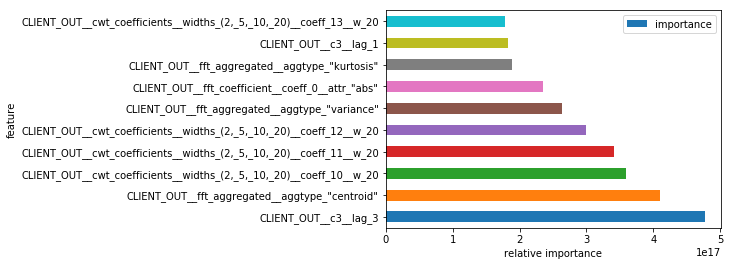

In [127]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
df_fi = pd.DataFrame(xgb.feature_name(), columns=['feature'])
df_fi['importance'] = list(xgb.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
# print(df_fi)
if True:
    plt.figure()
    df_fi.head(10).plot(kind='barh', x='feature', y='importance')
#     plt.title('Roc_auc is {}'.format(roc_auc_score(y_test.astype('int8'), y_pred)))
    plt.xlabel('relative importance')
    plt.show()

In [ ]:
# def make_feats_tar(start_train_date, start_valid_train_date):
feats_arr = []
target_arr = []
date = start_valid_date
mask = (train.DATE < date) & (train.DATE >= date - timedelta(33)) & (train.ATM_ID<=60)
new_train = train[mask].reset_index(drop=True)

for date in pd.date_range(start_valid_date, start_test_date, closed='left'):
    mask = (new_train.DATE < date) & (new_train.DATE >= date - timedelta(33)) & (new_train.ATM_ID<=60)
    feats = extract_features(new_train[mask], column_id='ATM_ID', column_sort='DATE', 
                     default_fc_parameters=EfficientFCParameters(), 
                            disable_progressbar=True)
    target = xgb.predict(feats.values)
    target = pd.DataFrame(target, columns=['CLIENT_OUT'])
    target['ATM_ID'] = train[mask2].ATM_ID.values
    target['DATE'] = date
    new_train = pd.concat([new_train, target])
    print(target.DATE.max(), new_train.DATE.max())
new_train.tail()
#         mask2 = (train.DATE == date) & (train.ATM_ID<=60)
#         target = train[mask2].CLIENT_OUT.reset_index(drop=True)
# feats_arr.append(feats)
# target_arr.append(target)
# feats_arr = pd.concat(feats_arr)
# target_arr = pd.concat(target_arr)
# #     return feats_arr, target_arr
# x_train, y_train = make_feats_tar(start_train_date, start_valid_train_date)

In [181]:
start_test_date = pd.datetime(2017, 8, 16)
start_valid_date = pd.datetime(2017,7,14)
mask3 = (new_train.DATE < start_test_date) & (new_train.DATE >= start_test_date - timedelta(33)) & (new_train.ATM_ID<=60)
mask4 = (train.DATE < start_test_date) & (train.DATE >= start_test_date - timedelta(33)) & (train.ATM_ID<=60)
train[mask4].shape
new_train['CLIENT_OUT'] = np.abs(new_train['CLIENT_OUT'])
new_train

,ATM_ID,CLIENT_OUT,DATE
0,0,274400.000000,2017-06-11
1,0,209800.000000,2017-06-12
2,0,598800.000000,2017-06-13
3,0,461200.000000,2017-06-14
4,0,656600.000000,2017-06-15
5,0,597600.000000,2017-06-16
6,0,265700.000000,2017-06-17
7,0,402400.000000,2017-06-18
8,0,427600.000000,2017-06-19
9,0,598800.000000,2017-06-20


In [165]:
import os
import numpy as np
import pandas as pd
import sys
import json 

def score_series(y_true, y_pred):
    """
        Expects y_true and y_pred to be 1d arrays of the same lenght
    """
    return np.mean(np.abs(y_true - y_pred))/np.mean(np.abs(y_true))

def scorer(df_true, df_pred):
   
    scores = []
    for ID in df_true.ATM_ID.unique():
        
        df_true_part = df_true.query('ATM_ID == @ID')
        df_pred_part = df_pred.query('ATM_ID == @ID')
        
        
        if df_true_part.shape[0] != df_pred_part.shape[0]:
            print("$Wrong number of predictions for ATM_ID = %d$" % ID)
            sys.exit(4)

        if not np.all(df_true_part.DATE == df_pred_part.DATE):
            print("$Could not parse dates for ATM_ID = %d. Wrong format\encoding? Duplicated/wrong dates?$" % ID)
            sys.exit(4)
       
        score = score_series(df_true_part.CLIENT_OUT, df_pred_part.CLIENT_OUT)
        scores.append(score)
    
    return np.mean(scores)



1.337840719142295

In [182]:
df_pred = new_train[mask3].sort_values(['ATM_ID', 'DATE']).reset_index(drop=True)
df_true = train[mask4].reset_index(drop=True)
scorer(df_true, df_pred)

1.3236478024925862

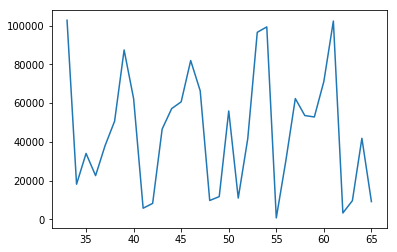

In [183]:
df_pred[df_pred.ATM_ID==2].CLIENT_OUT.plot()

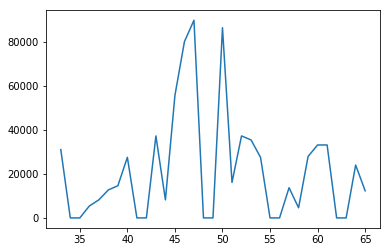

In [184]:
df_true[df_true.ATM_ID==2].CLIENT_OUT.plot()